In [ ]:
import os
import logging
from pathlib import Path
from glob import glob
import warnings
warnings.simplefilter("ignore", UserWarning)
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from tqdm import tqdm
import torch
from einops import rearrange
from captum.attr import LayerGradCam, LayerAttribution

from sage.config import load_config
from sage.training.trainer import MRITrainer
from sage.visualization.vistool import plot_vismap, Assembled

logging.basicConfig(
    format="[%(asctime)s] %(levelname)s - %(name)s: %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)

: 

In [150]:
RESULT_DIR = "../resnet256_augmentation_checkpoints/"
RESULT_DIR = "../resnet256_naive_checkpoints/"
checkpoint_lists = sorted(glob(f"{RESULT_DIR}/*"))

checkpoint = Path(checkpoint_lists[0])

In [3]:
def load_model_ckpts(path: Path, epoch: int):

    epoch = str(epoch).zfill(3)
    ckpts = dict()
    for model_name in ("encoder", "regressor"):

        ckpt = list(path.glob(f"./{model_name}/ep{epoch}*.pt"))
        assert len(ckpt) == 1
        ckpts[model_name] = ckpt[0]

    mae = float(str(ckpt[0]).split("mae")[-1].split(".pt")[0])

    return ckpts, mae

In [151]:
load_model_ckpts(checkpoint, 0)

({'encoder': PosixPath('../resnet256_naive_checkpoints/20211130-1342_resnet/encoder/ep000_mae55.36.pt'),
  'regressor': PosixPath('../resnet256_naive_checkpoints/20211130-1342_resnet/regressor/ep000_mae55.36.pt')},
 55.36)

In [152]:
cfg = load_config(Path(checkpoint, "config.yml"))
cfg.force_cpu = True

trainer = MRITrainer(cfg)
model = Assembled(trainer.models["encoder"], trainer.models["regressor"]).to("cuda")
ckpt_dict, mae = load_model_ckpts(checkpoint, 3)
model.load_weight(ckpt_dict)

[12/14/2021 14:02:49] INFO - sage.data.dataloader: Initialize dataset.
[12/14/2021 14:02:49] INFO - sage.data.dataloader: Initialize dataset.


Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634533


[12/14/2021 14:02:49] INFO - sage.data.dataloader: Initialize dataset.


TOTAL TRAIN 1044 | VALID 262 | TEST 146
MIXED PRECISION:: True
Weights successfully loaded!


In [7]:
layer_gc = LayerGradCam(model, model.encoder.layer1[0].conv1)

In [8]:
for x, y, d in trainer.test_dataloader:
    x, y, d = map(lambda x: x.to("cuda"), (x, y, d))
    break

In [9]:
attr = layer_gc.attribute(x)

In [10]:
upsampled_attr = LayerAttribution.interpolate(attr, (96, 96, 96), interpolate_mode="trilinear")

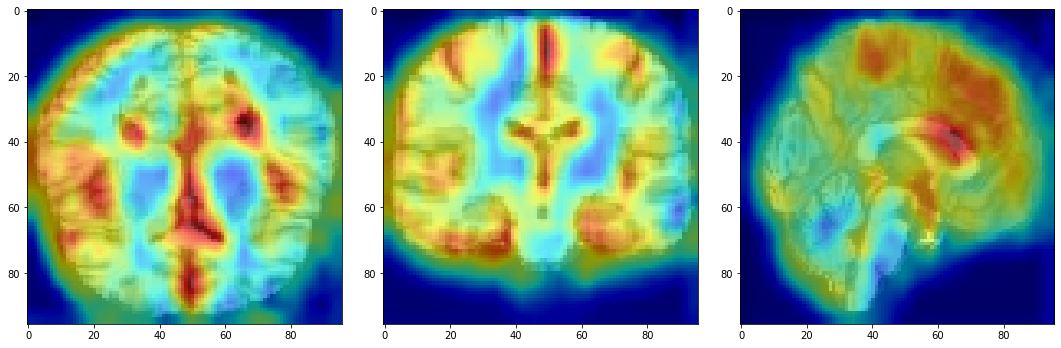

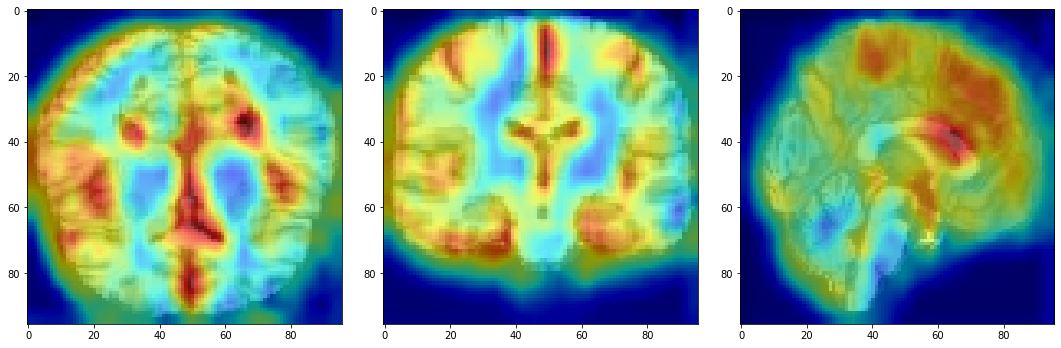

In [11]:
plot_vismap(x.cpu().detach(), upsampled_attr.cpu().detach(), masked=False)

In [28]:
checkpoint = Path(checkpoint)
cfg = load_config(Path(checkpoint, "config.yml"))
logger.info(f"Starting seed {cfg.seed}")
cfg.force_cpu = True

saliency_map_dir = Path(f"{checkpoint}/npy_maps/")
os.makedirs(saliency_map_dir, exist_ok=True)
trainer = MRITrainer(cfg)
model = Assembled(trainer.models["encoder"], trainer.models["regressor"]).to("cuda")

def get_saliency_map(epoch, layer_idx):

    ckpt_dict, mae = load_model_ckpts(checkpoint, e)
    model.load_weight(ckpt_dict)
    logger.info(f"Load checkpoint epoch={e} | mae={mae}")

    layer_gc = LayerGradCam(model, model.conv_layers()[layer_idx])

    saliency_map = []
    for x, y, _ in trainer.test_dataloader:

        x, y = map(lambda x: x.to("cuda"), (x, y))
        attr = layer_gc.attribute(x)
        upsampled_attr = LayerAttribution.interpolate(attr, (96, 96, 96), interpolate_mode="trilinear").cpu().detach()
        saliency_map.append(upsampled_attr)

    saliency_map = torch.cat(saliency_map, dim=0).squeeze()
    num_test = saliency_map.shape[0]

    saliency_map_avg = torch.sum(saliency_map, dim=0) / num_test

    return saliency_map_avg

[12/10/2021 14:28:16] INFO - __main__: Starting seed 43
[12/10/2021 14:28:16] INFO - sage.data.dataloader: Initialize dataset.
[12/10/2021 14:28:17] INFO - sage.data.dataloader: Check header /home/hoesung/hoesung_save2/daehyun/brainmask_mni/IXI002-Guys-0828-T1-brainmask.npy.
[12/10/2021 14:28:17] INFO - sage.data.dataloader: Initialize dataset.
[12/10/2021 14:28:17] INFO - sage.data.dataloader: Check header /home/hoesung/hoesung_save2/daehyun/brainmask_mni/IXI002-Guys-0828-T1-brainmask.npy.
[12/10/2021 14:28:17] INFO - sage.data.dataloader: Initialize dataset.
[12/10/2021 14:28:17] INFO - sage.data.dataloader: Check header /home/hoesung/hoesung_save2/daehyun/brainmask_mni/IXI002-Guys-0828-T1-brainmask.npy.


Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634533
TOTAL TRAIN 1044 | VALID 262 | TEST 146
MIXED PRECISION:: True


In [30]:
saliency = get_saliency_map(3, 4)

[12/10/2021 14:28:23] INFO - __main__: Load checkpoint epoch=1 | mae=40.29


Weights successfully loaded!


In [155]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [189]:
for checkpoint in checkpoint_lists[30:31]:

    checkpoint = Path(checkpoint)
    cfg = load_config(Path(checkpoint, "config.yml"))
    logger.info(f"Starting seed {cfg.seed}")
    cfg.force_cpu = True

    saliency_mm_dir = Path(f"{checkpoint}/npy_mm/")
    saliency_std_dir = Path(f"{checkpoint}/npy_std/")
    os.makedirs(saliency_map_dir, exist_ok=True)
    trainer = MRITrainer(cfg)
    model = Assembled(trainer.models["encoder"], trainer.models["regressor"]).to("cuda")

    saliency_map_ep_naive = dict()
    for e in range(0, 150):
        try:
            ckpt_dict, mae = load_model_ckpts(checkpoint, e)
            model.load_weight(ckpt_dict)
            logger.info(f"Load checkpoint epoch={e} | mae={mae}")
        except:
            break
        
        saliency_map_ep_naive[e] = []
        for layer_idx, conv_layer in tqdm(enumerate(model.conv_layers())):

            layer_save_mm_dir = Path(f"{saliency_mm_dir}/layer{layer_idx}/")
            layer_save_std_dir = Path(f"{saliency_std_dir}/layer{layer_idx}/")

            os.makedirs(layer_save_dir, exist_ok=True)
            logger.info(f"Layer {layer_idx}: {conv_layer}")
            layer_gc = LayerGradCam(model, conv_layer)

            saliency_map = []
            for x, y, _ in trainer.test_dataloader:

                x, y = map(lambda x: x.to("cuda"), (x, y))
                attr = layer_gc.attribute(x)
                upsampled_attr = LayerAttribution.interpolate(attr, (96, 96, 96), interpolate_mode="trilinear").cpu().detach()
                saliency_map.append(upsampled_attr)

            saliency_map = rearrange(torch.cat(saliency_map, dim=0), 'b c h w d -> b (c h w d)').numpy()
            num_test = saliency_map.shape[0]

            scaler = MinMaxScaler()
            saliency_minmax = rearrange(scaler.fit_transform(saliency_map.T), '(h w d) b -> d w h b', h=96, w=96, d=96).T
            saliency_map_avg = saliency_minmax.sum(axis=0) / num_test
            # saliency_map_ep_naive[e].append((conv_layer, saliency_map_avg))
            np.save(f"{layer_save_mm_dir}/ep{str(e).zfill(3)}_mae{mae}.npy", saliency_map_avg)

            scaler = StandardScaler()
            saliency_std = rearrange(scaler.fit_transform(saliency_map.T), '(h w d) b -> d w h b', h=96, w=96, d=96).T
            saliency_map_avg = saliency_std.sum(axis=0) / num_test
            # saliency_map_ep_naive[e].append((conv_layer, saliency_map_avg))
            np.save(f"{layer_save_std_dir}/ep{str(e).zfill(3)}_mae{mae}.npy", saliency_map_avg)

        # clear_output()
        break
    break

[12/14/2021 19:12:22] INFO - __main__: Starting seed 72
[12/14/2021 19:12:22] INFO - sage.data.dataloader: Initialize dataset.
[12/14/2021 19:12:22] INFO - sage.data.dataloader: Initialize dataset.
[12/14/2021 19:12:22] INFO - sage.data.dataloader: Initialize dataset.
[12/14/2021 19:12:22] INFO - __main__: Load checkpoint epoch=0 | mae=55.08
0it [00:00, ?it/s][12/14/2021 19:12:22] INFO - __main__: Layer 0: Conv3d(1, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)


Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634533
TOTAL TRAIN 1044 | VALID 262 | TEST 146
MIXED PRECISION:: True
Weights successfully loaded!


0it [00:04, ?it/s]


In [195]:
saliency_minmax.sum(axis=0).shape

(96, 96, 96)

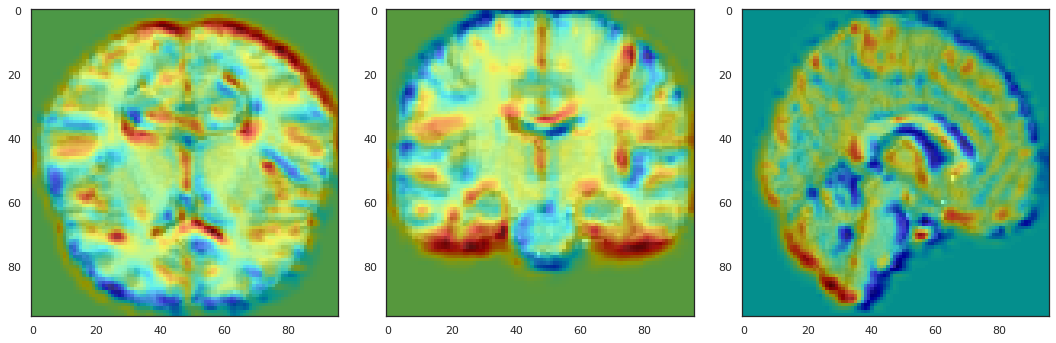

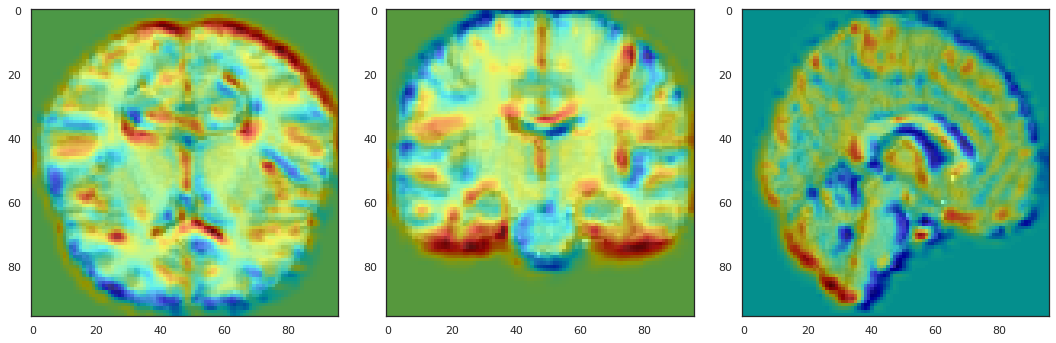

In [173]:
plot_vismap(x.cpu().detach(), saliency_map_retreived, masked=False)

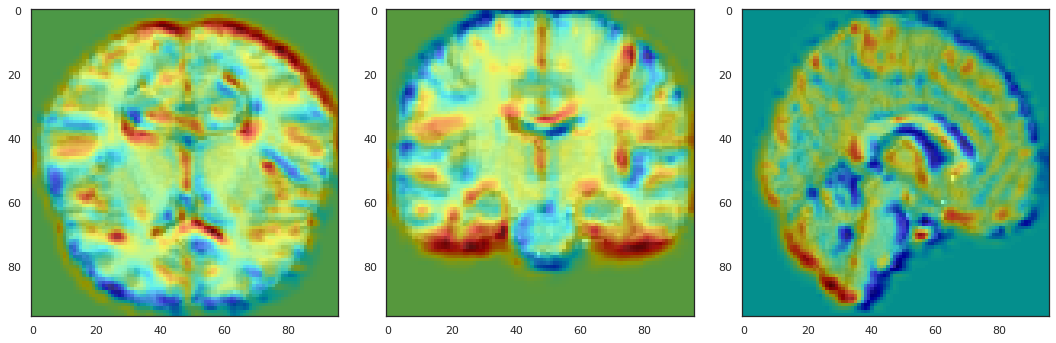

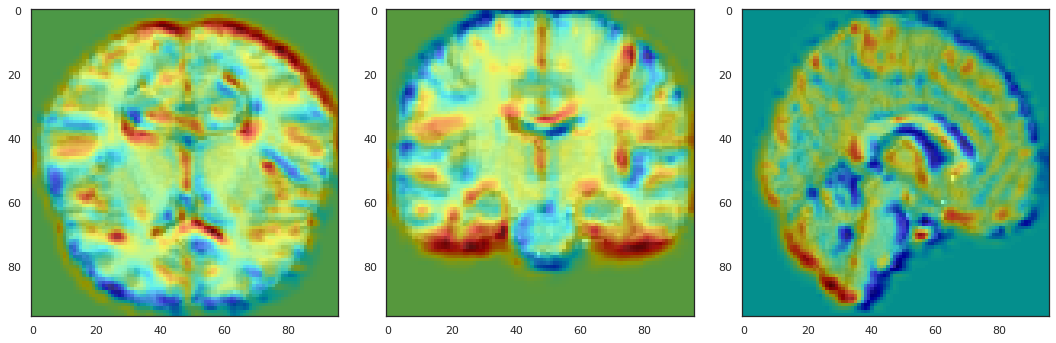

In [190]:
plot_vismap(x.cpu().detach(), saliency_std, masked=False)

In [82]:
conv_layer = model.conv_layers()[0]
layer_gc = LayerGradCam(model, conv_layer)

saliency_map = []
for x, y, _ in trainer.test_dataloader:

    x, y = map(lambda x: x.to("cuda"), (x, y))
    attr = layer_gc.attribute(x)
    upsampled_attr = LayerAttribution.interpolate(attr, (96, 96, 96), interpolate_mode="trilinear").cpu().detach()
    saliency_map.append(upsampled_attr)

In [116]:
epoch = 10
layer_idx = 1
saliency_map = {
    epoch: np.log1p(np.random.choice(saliency_map_ep[epoch][layer_idx][1].flatten(), 200000) )
    for epoch in range(len(saliency_map_ep.keys())) if epoch % 5 == 0 
}

In [146]:
sample = {
    epoch: np.random.randint(0, 1000, 200) for epoch in range(20)
}

In [147]:
df = pd.DataFrame.from_dict(sample, orient="index")
df = df.reset_index()
df = df.rename(columns={'index': 'epoch'})

grad_df = df.melt(id_vars='epoch', value_name='saliency')
grad_df = grad_df.sort_values('epoch')
grad_df = grad_df.drop(columns='variable').reset_index(drop=True)
grad_df = grad_df.dropna()

grad_df['saliency'] = grad_df.saliency.astype(np.float32)

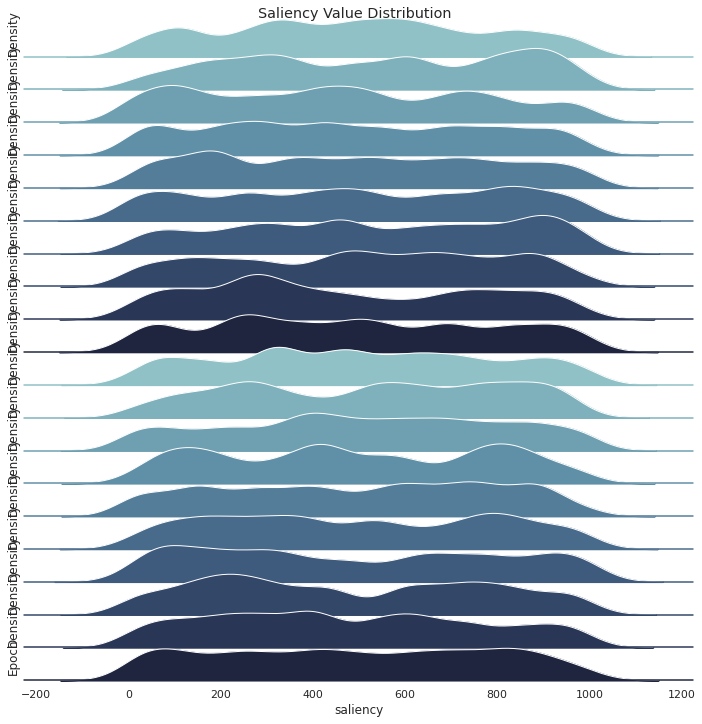

In [149]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(len(saliency_map), rot=-.25, light=.7)

g = sns.FacetGrid(grad_df,
                row="epoch",
                hue="epoch",
                aspect=20,
                height=.5,
                palette=pal)

g.map(sns.kdeplot, "saliency",
        bw_adjust=.5, clip_on=False,
        fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "saliency", clip_on=False, color="w", lw=1, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=1.5, clip_on=False)


filter_module_labels = list(grad_df.epoch.unique())

def label(x, color, label):
    ax = plt.gca()
    # 표시하기로 지정한 라벨만 표시하며
    # 지정이 안되어있을시 모든 라벨 표시
    if label not in filter_module_labels:
        return 
    ax.text(0, 0.03, label, fontweight="bold", color=color,
    ha="left", va="center", transform=ax.transAxes)
g.map(label, "saliency")

# 겹쳐서 그리기
g.fig.subplots_adjust(hspace=-.3)
# overlap하며 시각적으로 방해되는 요소 제거
g.set_titles("")
g.despine(bottom=True, left=True)

# x축을 로그스케일로 직접 변경했기 때문에 tick을 직접 지정해준다
g.set(yticks=[])

g.fig.suptitle('Saliency Value Distribution')
plt.ylabel('Epoch')
plt.show();